# Неделя 3. Вторник 
## Обучение с учителем

In [107]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import optuna

### Применение ансаблей моделей для задач классификации и регрессии

1. Загружаем предобработанный датасет (либо загружаем и очищаем, если не осталось сохраненной версии)

In [136]:
df = pd.read_csv('aux/heart.csv')
X , y = df.drop('HeartDisease', axis=1), df['HeartDisease']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [132]:
my_imputer = ColumnTransformer(
    transformers = 
    [
        ('Age_imp', SimpleImputer(strategy='median'), ['Age'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

one_hot_encoding_columns = ['ChestPainType', 'RestingECG']
ordinal_encoding_columns = ['Sex', 'ST_Slope', 'ExerciseAngina']

my_cat_encoder = ColumnTransformer(
    [
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('ordinal_encoding_columns', OrdinalEncoder(), ordinal_encoding_columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

num_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

my_scaler = ColumnTransformer(
    [
        ('num_scaler', StandardScaler(), num_columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('encoder', my_cat_encoder),
        ('scaler', my_scaler)
    ]
)


preprocessor.fit_transform(X_train, y_train)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Sex,ST_Slope,ExerciseAngina,FastingBS
485,0.969838,0.339016,0.127137,-0.324520,0.317046,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1
486,0.117054,-1.266031,0.099443,1.689837,-0.440356,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1
117,0.543446,-0.159102,1.244113,-0.247045,0.601071,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1
361,-0.735729,1.501291,-1.876035,-0.479470,-0.819056,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0
296,-0.415935,0.671094,-1.876035,0.101594,-0.156330,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-0.309337,0.117630,-0.399042,0.527708,1.074447,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
201,-0.842327,-0.712567,0.247142,0.527708,-0.819056,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0
462,0.543446,-0.601874,0.274836,-0.750634,0.411721,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
252,0.756642,-0.435834,0.819477,-0.828109,-0.819056,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0


In [114]:
ml_pipeline_dt = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_split=3))
    ]
)

2. К прежним датасетам применяем ансамбли моделей: 
    - `RandomForest`
    - `Voting`
    - `Catboost`([https://catboost.ai/en/docs/concepts/python-installation](https://catboost.ai/en/docs/concepts/python-installation))
    - `LightGBM`([https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html))
    - `XGBoost` ([https://xgboost.readthedocs.io/en/latest/install.html](https://xgboost.readthedocs.io/en/latest/install.html))

# ❓
Какие значения по умолчанию заданы в случайном лесе для числа деревьев и их глубины?

> 100 and None

`RandomForest`

In [95]:
rf = RandomForestClassifier(n_estimators=340, max_depth=10, min_samples_split=2, random_state=42)

ml_pipeline_rf = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', rf)
    ]
)

In [96]:
ml_pipeline_rf.fit(X_train, y_train)
print('train accuracy:', accuracy_score(y_train, ml_pipeline_rf.predict(X_train)))
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline_rf.predict(X_valid))) 

train accuracy: 0.9931880108991825
valid accuracy: 0.907608695652174


`Voting`

In [10]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)
knn = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance')

vc = VotingClassifier(
    [
        ('LogReg', lr),
        ('DecTree', dt),
        ('neibor', knn)
    ]
)

ml_pipeline_vc = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', vc)
    ]
)

In [11]:
ml_pipeline_vc.fit(X_train, y_train)
print('train accuracy:', accuracy_score(y_train, ml_pipeline_vc.predict(X_train)))
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline_vc.predict(X_valid))) 

train accuracy: 0.944141689373297
valid accuracy: 0.8967391304347826


`Catboost`

In [12]:
preprocessor_X_train = preprocessor.transform(X_train)
preprocessor_X_valid = preprocessor.transform(X_valid)

In [118]:
cb = CatBoostClassifier(eval_metric='Accuracy', learning_rate=0.051, iterations=310, depth=6)
cb.fit(
    preprocessor_X_train,
    y_train,
    eval_set=(preprocessor_X_valid, y_valid),
    verbose=False,
    plot=False
)

In [119]:
print('train accuracy:', accuracy_score(y_train, cb.predict(preprocessor_X_train)))
print('valid accuracy:', accuracy_score(y_valid, cb.predict(preprocessor_X_valid)))

train accuracy: 0.9318801089918256
valid accuracy: 0.9130434782608695


`LightGBM`

In [58]:
lgb = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=400,
    max_depth=5,
    verbosity=-1
)

lgb.fit(preprocessor_X_train, y_train)

LGBMClassifier(max_depth=5, n_estimators=400, verbosity=-1)

In [59]:
print('train accuracy:', accuracy_score(y_train, lgb.predict(preprocessor_X_train)))
print('valid accuracy:', accuracy_score(y_valid, lgb.predict(preprocessor_X_valid)))

train accuracy: 1.0
valid accuracy: 0.8478260869565217


`XGBoost`

In [98]:
xgb = XGBClassifier(  
    learning_rate=0.051,
    n_estimators=330,
    max_depth=5,
    verbosity=0
)


xgb.fit(preprocessor_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.051, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=330, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [99]:
print('train accuracy:', accuracy_score(y_train, xgb.predict(preprocessor_X_train)))
print('valid accuracy:', accuracy_score(y_valid, xgb.predict(preprocessor_X_valid)))

train accuracy: 0.997275204359673
valid accuracy: 0.8641304347826086


3. Прогоните модели через `optuna`, определяем лучшие параметры и сохраняем результат в словарь вида:
    ```python
    results = {'model_name' : best_result}
    ```

Типичные параметры для оптимизации градиентного бустинга: 
* число итераций алгоритма
* глубина деревьев
* скорость обучения (`learning_rate`). 
Чтобы попробовать оптимизировать модели, стоит обратиться к документации: разные реализации будут предлагать разные варианты параметров. 

   > Для классификации используем метрику `accuracy_score`

In [94]:
results = {}

def objective(trial):
    model_name = trial.suggest_categorical('model', ['catboost', 'xgboost', 'lightgbm', 'voting', 'randomforest'])
    model_params = {}

    if model_name == 'catboost':
        model = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 10, 400, step=10),
            depth=trial.suggest_int('depth', 2, 10, step=1),
            learning_rate=trial.suggest_float('learning_rate', 0.001, 0.8, step=0.01),
            verbose=0
        )
        model_params = {
            'iterations': trial.params['iterations'],
            'depth': trial.params['depth'],
            'learning_rate': trial.params['learning_rate']
        }
    
    elif model_name == 'xgboost':
        model = XGBClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 400, step=10),
            max_depth=trial.suggest_int('max_depth', 2, 10, step=1),
            learning_rate=trial.suggest_float('learning_rate', 0.001, 0.8, step=0.01),
            verbosity=0
        )
        model_params = {
            'n_estimators': trial.params['n_estimators'],
            'max_depth': trial.params['max_depth'],
            'learning_rate': trial.params['learning_rate']
        }
        
    elif model_name == 'lightgbm':
        model = LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 400, step=10),
            max_depth=trial.suggest_int('max_depth', 2, 10, step=1),
            learning_rate=trial.suggest_float('learning_rate', 0.001, 0.8, step=0.01),
            verbosity=-1
        )
        model_params = {
            'n_estimators': trial.params['n_estimators'],
            'max_depth': trial.params['max_depth'],
            'learning_rate': trial.params['learning_rate']
        }

    elif model_name == 'voting':
        estimators = [
            ('logreg', LogisticRegression(
                C=trial.suggest_float('logreg_C', 0.01, 10.0, step=0.1),
                max_iter=trial.suggest_int('logreg_max_iter', 50, 300, step=10),
                solver='liblinear',
                verbose=0
            )),
            ('dec_tree', DecisionTreeClassifier(
                max_depth=trial.suggest_int('dec_tree_max_depth', 2, 10, step=1),
                min_samples_split=trial.suggest_int('dec_tree_min_samples_split', 2, 10, step=1)
            )),
            ('kneighbors', KNeighborsClassifier(
                n_neighbors=trial.suggest_int('kneighbors_n_neighbors', 1, 20, step=1),
                weights=trial.suggest_categorical('kneighbors_weights', ['uniform', 'distance']),
                algorithm=trial.suggest_categorical('kneighbors_algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
            ))
        ]
        model = VotingClassifier(estimators=estimators, voting='soft')

        model_params = {
            'logreg_C': trial.params['logreg_C'],
            'logreg_max_iter': trial.params['logreg_max_iter'],
            'dec_tree_max_depth': trial.params['dec_tree_max_depth'],
            'dec_tree_min_samples_split': trial.params['dec_tree_min_samples_split'],
            'kneighbors_n_neighbors': trial.params['kneighbors_n_neighbors'],
            'kneighbors_weights': trial.params['kneighbors_weights'],
            'kneighbors_algorithm': trial.params['kneighbors_algorithm']
        }

    elif model_name == 'randomforest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 400, step=10),
            max_depth=trial.suggest_int('max_depth', 2, 10, step=1),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10, step=1)
        )
        model_params = {
            'n_estimators': trial.params['n_estimators'],
            'max_depth': trial.params['max_depth'],
            'min_samples_split': trial.params['min_samples_split']
        }

    ml_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_val_score(ml_pipeline, X, y, cv=cv)
    accuracy = scores.mean()

    results[model_name] = {'accuracy': accuracy, 'params': model_params}

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Results:", results)

[I 2024-10-29 19:58:51,726] A new study created in memory with name: no-name-f980ba49-3f06-4553-9937-e01c50cc1b34
[I 2024-10-29 19:58:52,249] Trial 0 finished with value: 0.8539795675932526 and parameters: {'model': 'randomforest', 'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 8}. Best is trial 0 with value: 0.8539795675932526.
/home/oldmovielover/miniforge3/lib/python3.12/site-packages/optuna/distributions.py:689: UserWarning: The distribution is specified by [0.001, 0.8] and step=0.01, but the range is not divisible by `step`. It will be replaced by [0.001, 0.791].
  warnings.warn(
[I 2024-10-29 19:58:52,614] Trial 1 finished with value: 0.8637799952482774 and parameters: {'model': 'lightgbm', 'n_estimators': 110, 'max_depth': 8, 'learning_rate': 0.051000000000000004}. Best is trial 1 with value: 0.8637799952482774.
[I 2024-10-29 19:58:54,303] Trial 2 finished with value: 0.8572285578522214 and parameters: {'model': 'randomforest', 'n_estimators': 230, 'max_depth': 4, 'min

Best parameters: {'model': 'randomforest', 'n_estimators': 340, 'max_depth': 10, 'min_samples_split': 2}
Results: {'randomforest': {'accuracy': 0.8714005702067, 'params': {'n_estimators': 210, 'max_depth': 10, 'min_samples_split': 2}}, 'lightgbm': {'accuracy': 0.859432169161321, 'params': {'n_estimators': 380, 'max_depth': 10, 'learning_rate': 0.121}}, 'xgboost': {'accuracy': 0.8714183891660727, 'params': {'n_estimators': 330, 'max_depth': 5, 'learning_rate': 0.051000000000000004}}, 'voting': {'accuracy': 0.8528747921121406, 'params': {'logreg_C': 3.81, 'logreg_max_iter': 150, 'dec_tree_max_depth': 8, 'dec_tree_min_samples_split': 4, 'kneighbors_n_neighbors': 15, 'kneighbors_weights': 'distance', 'kneighbors_algorithm': 'ball_tree'}}, 'catboost': {'accuracy': 0.8703195533380852, 'params': {'iterations': 70, 'depth': 8, 'learning_rate': 0.431}}}


In [159]:
df_results = pd.DataFrame(results)
df_results

,randomforest,lightgbm,xgboost,voting,catboost
accuracy,0.871401,0.859432,0.871418,0.852875,0.87032
params,"{'n_estimators': 210, 'max_depth': 10, 'min_samples_split': 2}","{'n_estimators': 380, 'max_depth': 10, 'learning_rate': 0.121}","{'n_estimators': 330, 'max_depth': 5, 'learning_rate': 0.051000000000000004}","{'logreg_C': 3.81, 'logreg_max_iter': 150, 'dec_tree_max_depth': 8, 'dec_tree_min_samples_split': 4, 'kneighbors_n_neighbors': 15, 'kneighbors_weights': 'distance', 'kneighbors_algorithm': 'ball_tree'}","{'iterations': 70, 'depth': 8, 'learning_rate': 0.431}"


4. Превращаем словарь в `DataFrame` и сравниваем полученные результаты. Строим `bar_plot` для визуализации метрики качества. 

<Axes: xlabel='model', ylabel='accuracy'>

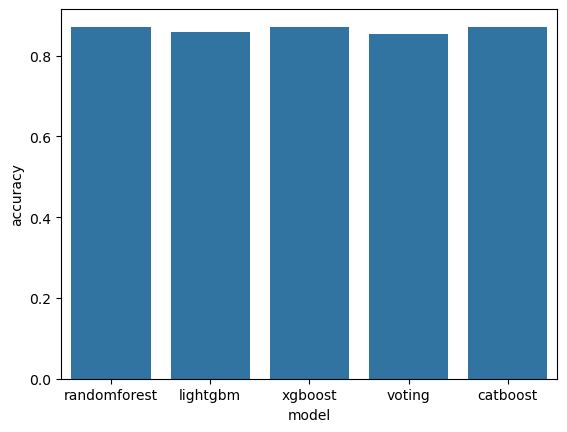

In [158]:
df1 = df_results.T.reset_index()
df1.columns = ['model', 'accuracy', 'params']
sns.barplot(x='model', y='accuracy', data=df1)

5. Выберете лучшую модель и попробуйте задеплоить ее в Streamlit.

* Создайте просто интерфейс для пользователя, куда бы он мог ввести необходимые данные, а вы бы ему вернули предсказание

In [133]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(n_estimators=340, max_depth=10, min_samples_split=2, random_state=42))
    ]
)

ml_pipeline.fit(X_train, y_train)

print('train accuracy:', accuracy_score(y_train, ml_pipeline.predict(X_train)))
print('valid accuracy:', accuracy_score(y_valid, ml_pipeline.predict(X_valid))) 

train accuracy: 0.9931880108991825
valid accuracy: 0.907608695652174


In [134]:
ml_pipeline

/home/oldmovielover/miniforge3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Age_imp',
                                                                   SimpleImputer(strategy='median'),
                                                                   ['Age'])],
                                                    verbose_feature_names_out=False)),
                                 ('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('one_hot_encoding_columns',
                                                                   OneHotEncoder(sparse_output=False),
                                                                   ['ChestPainType',...
                                                                   OrdinalEncoder(),
                                                                   ['Sex',
                                                                    'ST_Slope',
                                                                    'ExerciseAngina'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaler',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_scaler',
                                                                   StandardScaler(),
                                                                   ['Age',
                                                                    'RestingBP',
                                                                    'Cholesterol',
                                                                    'MaxHR',
                                                                    'Oldpeak'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=340,
                                        random_state=42))])

In [135]:
import joblib

joblib.dump(ml_pipeline, 'aux/ml_pipeline.pkl')

['aux/ml_pipeline.pkl']